# Inverted Pendulum Dynamics

CDS 110/ChE 105, Winter 2024 <br>
Richard M. Murray

In this lecture we investigate the nonlinear dynamics of an inverted pendulum system.  More information on this example can be found in [FBS2e](https://fbswiki.org/wiki/index.php?title=FBS), Examples 3.3 and 5.4.


In [1]:
# Import the packages needed for the examples included in this notebook
import numpy as np
import matplotlib.pyplot as plt
from math import pi

import control as ct

## System model

The dynamics for an inverted pendulum system can be written as:

$$
  \dfrac{d}{dt} \begin{bmatrix} \theta \\ \dot\theta\end{bmatrix} =
    \begin{bmatrix}
      \dot\theta \\
        \dfrac{m g l}{J_\text{t}} \sin \theta
      - \dfrac{b}{J_\text{t}} \dot\theta
      + \dfrac{l}{J_\text{t}} u \cos\theta
    \end{bmatrix}, \qquad
    y = \theta,
$$

where $m$ and $J_t = J + m l^2$ are the mass and (total) moment of inertia of the system to be balanced, $l$ is the distance from the base to the center of mass of the balanced body, $b$ is the coefficient of viscous friction, and $g$ is the acceleration due to gravity.

We begin by creating a nonlinear model of the system:

In [16]:
invpend_params = {'m': 1, 'l': 1, 'b': 0.5, 'g': 1}
def invpend_update(t, x, u, params):
    m, l, b, g = params['m'], params['l'], params['b'], params['g']
    umax = params.get('umax', 1)
    usat = np.clip(u[0], -umax, umax)
    return [x[1], -b/m * x[1] + (g * l / m) * np.sin(x[0] + usat/m)]
invpend = ct.nlsys(
    invpend_update, states=['theta', 'thdot'],
    inputs=['tau'], outputs=['theta', 'thdot'],
    params=invpend_params, name='invpend')
print(invpend)

<NonlinearIOSystem>: invpend
Inputs (1): ['tau']
Outputs (2): ['theta', 'thdot']
States (2): ['theta', 'thdot']

Update: <function invpend_update at 0x15322e700>
Output: None


## Open loop dynamics

The open loop dynamics of the system can be visualized using the `phase_plane_plot` command in python-control:

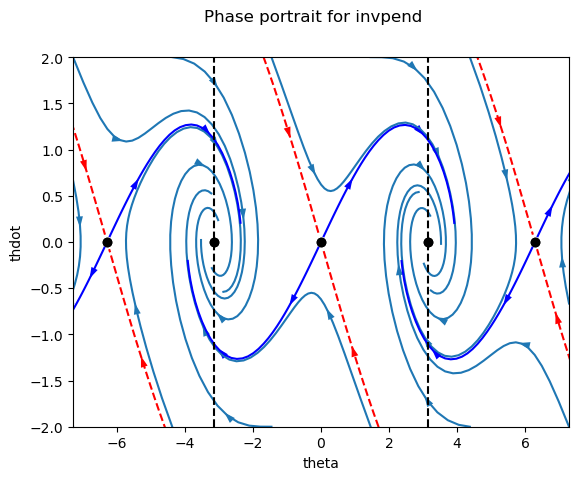

In [17]:
ct.phase_plane_plot(
    invpend, [-2*pi - 1, 2*pi + 1, -2, 2], 8),

# Draw lines at the downward equilibrium angles
plt.plot([-pi, -pi], [-2, 2], 'k--')
plt.plot([pi, pi], [-2, 2], 'k--')

We see that the vertical ($\theta = 0$) equilibrium point is unstable, but the downward equlibrium points ($\theta = \pm \pi$) are stable.

Note also the *separatrices* for the equilibrium point, which gives insighs into the regions of attraction (the red dashed line separates the two regions of attraction).

## Proportional feedback

We now stabilize the system using a simple proportional feedback controller:

$$u = -k_\text{p} \theta.$$

This controller can be designed as an input/output system that has no state dynamics, just a mapping from the inputs to the outputs:

In [18]:
# Set up the controller
def propctrl_output(t, x, u, params):
  kp = params.get('kp', 1)
  return -kp * (u[0] - u[1])
propctrl = ct.nlsys(
    None, propctrl_output, name="p_ctrl",
    inputs=['theta', 'r'], outputs='tau'
)
print(propctrl)

<NonlinearIOSystem>: p_ctrl
Inputs (2): ['theta', 'r']
Outputs (1): ['tau']
States (0): []

Update: <function NonlinearIOSystem.__init__.<locals>.<lambda> at 0x15345b560>
Output: <function propctrl_output at 0x15345b2e0>


Note that the input to the controller is the reference value $r$ (which will will always take to be zero), the measured output $y$, which is the angle $\theta$ for our system.  The output of the controller is the system input $u$, corresponding to the force applied to the wheels.

To connect the controller to the system, we use the [`interconnect`](https://python-control.readthedocs.io/en/latest/generated/control.interconnect.html) function, which will connect all signals that have the same names:

In [19]:
# Create the closed loop system
clsys = ct.interconnect(
    [invpend, propctrl], name='invpend w/ proportional feedback',
    inputs=['r'], outputs=['theta', 'tau'], params={'kp': 1})
print(clsys)

<InterconnectedSystem>: invpend w/ proportional feedback
Inputs (1): ['r']
Outputs (2): ['theta', 'tau']
States (2): ['invpend_theta', 'invpend_thdot']

Update: <function InterconnectedSystem.__init__.<locals>.updfcn at 0x15345af20>
Output: <function InterconnectedSystem.__init__.<locals>.outfcn at 0x15345ae80>


/Users/murray/src/python-control/murrayrm/control/nlsys.py:1208: UserWarning: Unused output(s) in InterconnectedSystem: (0, 1) : invpend.thdot
  warn(msg)


We can now linearize the closed loop system at different gains and compute the eigenvalues to check for stability:

In [20]:
# Solution
for kp in [0, 1, 10]:
  print("kp = ", kp, "; poles = ", clsys.linearize([0, 0], [0], params={'kp': kp}).poles())

kp =  0 ; poles =  [ 0.78077641+0.j -1.28077641+0.j]
kp =  1 ; poles =  [ 0. +0.j -0.5+0.j]
kp =  10 ; poles =  [-0.25+2.98956519j -0.25-2.98956519j]


We see that at $k_\text{p} = 10$ the eigenvalues (poles) of the closed loop system both have negative real part, and so the system is stabilized.

### Phase portrait

To study the resuling dynamics, we try plotting a phase plot using the same commands as before, but now for the closed loop system (with appropriate proportional gain):

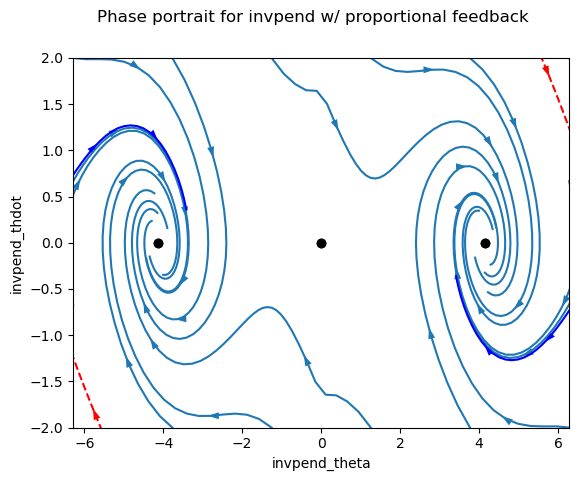

In [21]:
ct.phase_plane_plot(
    clsys, [-2*pi, 2*pi, -2, 2], 8, params={'kp': 10});

### Improved phase portrait

This plot is not very useful and has several errors.  It shows the limitations of the default parameter values for the `phase_plane_plot` command.

Some things to notice in this plot:
* The equilibrium point at $\theta = 0$ is not showing up.  This happens because the grid spacing is such that we don't find that point.

To fix these issues, we can do a couple of things:
* Restrict the range of the plot from $-\pi$ to $\pi$, which means that grid used to calculate the equilibrium point is a bit finer.
* Reset the grid spacing, so that we have more initial conditions around the edge of the plot and a finer search for equilibrium points.

Here's some improved code:

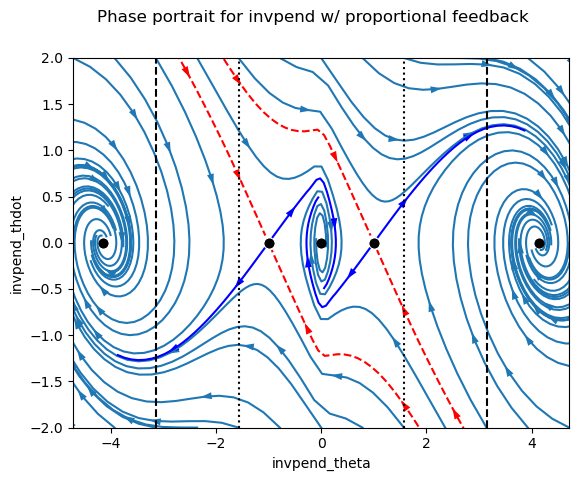

In [22]:
kp_params = {'kp': 10}
ct.phase_plane_plot(
    clsys, [-1.5 * pi, 1.5 * pi, -2, 2], 8,
    gridspec=[13, 7], params=kp_params,
    plot_separatrices={'timedata': 5})
plt.plot([-pi, -pi], [-2, 2], 'k--', [ pi,  pi], [-2, 2], 'k--')
plt.plot([-pi/2, -pi/2], [-2, 2], 'k:', [ pi/2,  pi/2], [-2, 2], 'k:')

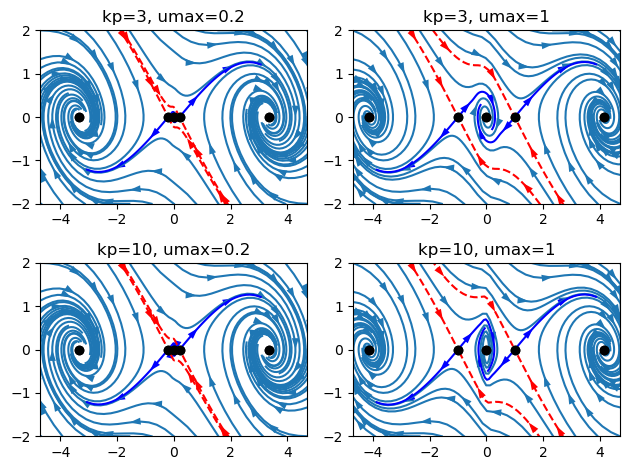

In [23]:
# Play around with some paramters to see what happens
fig, axs = plt.subplots(2, 2)
for i, kp in enumerate([3, 10]):
  for j, umax in enumerate([0.2, 1]):
    ct.phase_plane_plot(
      clsys, [-1.5 * pi, 1.5 * pi, -2, 2], 8,
      gridspec=[13, 7], plot_separatrices={'timedata': 5},
      params={'kp': kp, 'umax': umax}, ax=axs[i, j])
    axs[i, j].set_title(f"{kp=}, {umax=}")
plt.tight_layout()

## State space controller

For the proportional controller, we have limited control over the dynamics of the closed loop system.  For example, we see that the solutions near the origin are highly oscillatory in both the $k_\text{p} = 3$ and $k_\text{p} = 10$ cases.

An alternative is to use "full state feedback", in which we set

$$
u = -K (x - x_\text{d}) = -k_1 (\theta - \theta_d) - k_2 (\dot\theta - \dot\theta_d).
$$

To compute the gains, we make use of the `place` command, applied to the linearized system:

In [24]:
# Linearize the system
P = invpend.linearize([0, 0], [0])

# Place the closed loop eigenvalues (poles) at desired locations
K = ct.place(P.A, P.B, [-1 + 0.1j, -1 - 0.1j])
print(f"{K=}")

K=array([[2.01, 1.5 ]])


In [25]:
def statefbk_output(t, x, u, params):
  K = params.get('K', np.array([0, 0]))
  return -K @ (u[0:2] - u[2:])
statefbk = ct.nlsys(
    None, statefbk_output, name="k_ctrl",
    inputs=['theta', 'thdot', 'theta_d', 'thdot_d'], outputs='tau'
)
print(statefbk)

<NonlinearIOSystem>: k_ctrl
Inputs (4): ['theta', 'thdot', 'theta_d', 'thdot_d']
Outputs (1): ['tau']
States (0): []

Update: <function NonlinearIOSystem.__init__.<locals>.<lambda> at 0x1534e0180>
Output: <function statefbk_output at 0x1534e0a40>


In [26]:
clsys_sf = ct.interconnect(
    [invpend, statefbk], name='invpend w/ state feedback',
    inputs=['theta_d', 'thdot_d'], outputs=['theta', 'tau'], params={'kp': 1})
print(clsys_sf)

<InterconnectedSystem>: invpend w/ state feedback
Inputs (2): ['theta_d', 'thdot_d']
Outputs (2): ['theta', 'tau']
States (2): ['invpend_theta', 'invpend_thdot']

Update: <function InterconnectedSystem.__init__.<locals>.updfcn at 0x1534e20c0>
Output: <function InterconnectedSystem.__init__.<locals>.outfcn at 0x1534e0ae0>


### Phase portrait

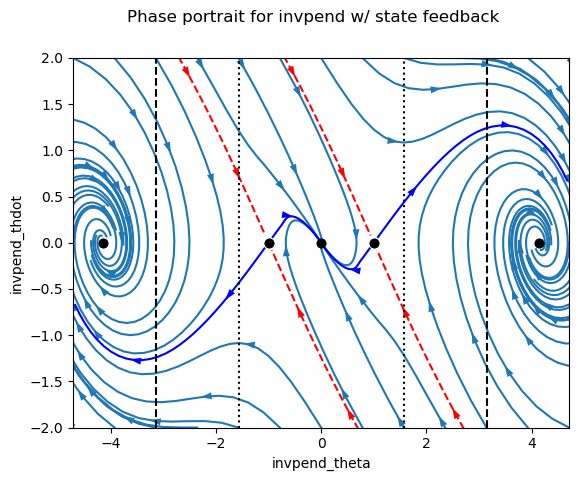

In [27]:
ct.phase_plane_plot(
    clsys_sf, [-1.5 * pi, 1.5 * pi, -2, 2], 8,
    gridspec=[13, 7], params={'K': K})
plt.plot([-pi, -pi], [-2, 2], 'k--', [ pi,  pi], [-2, 2], 'k--')
plt.plot([-pi/2, -pi/2], [-2, 2], 'k:', [ pi/2,  pi/2], [-2, 2], 'k:')

Note that the closed loop response around the upright equilibrium point is much less oscillatory (consistent with where we placed the closed loop eigenvalues of the system dynamics).

## Things to try

Here are some things to try with the above code:
* Try changing the locations of the closed loop eigenvalues in the `place` command
* Try reseting the limits of the control action (`umax`)
* Try leaving the state space controller fixed but changing the parameters of the system dynamics ($m$, $l$, $b$).  Does the controller still stabilize the system?